## Student details:
Student name: **Siddharth Prince**
Student ID: **23052058**

# Manufacturing Inspection
In this assignment you will apply simple image processing techniques to determine the level of liquid in a bottle.
This simple approach allows us to identify overfilled bottles on a production line.

![link text](https://github.com/tonyscan6003/etivities/blob/main/manu_inspect.JPG?raw=true)



Before beginning this exercise you should think about and engage with your peers (on the forum) about the likely sequence of steps necessary to complete the exercise. As you make progress you can discuss what approaches are working well or are failing. Some useful information is provided below. Much of the necessary code can be found in the example notebooks provided.

*   [OpenCV2 Threshold](https://docs.opencv.org/4.5.1/d7/d4d/tutorial_py_thresholding.html) (example of use here)
*   [OpenCV2 Morphology Operations](https://docs.opencv.org/4.5.2/d9/d61/tutorial_py_morphological_ops.htmlf) (example of use here)
*   [Canny Algorithm](https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html) (example of use)
*   [Hough Algorithm](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html) (example of use)





# Housekeeping:
Import packages, read test image, define helper functions.

In [1]:
import numpy as np
from skimage import feature
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import urllib.request


In [2]:
# function to read images from Web addresses.
def url_to_image(url):
	resp = urllib.request.urlopen(url)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB
	return temp_image

A Mask for the Region of Interest containing specific edges from the image can be created using the cv2.fillPoly command that can create a a filled region, the number of sides of the region is determined by the number of vertices applied. If a rectangle is required then 4 vertices are needed.

In [3]:
"""
# In order to create a rectangular mask 4 points are needed
# These are arranged clockwise (starting at any corner of the rectangle).
# NB Coordinates are given in the form (width,height) with the origin in the top left

e.g.
l1 = [50,150]
l2 = [50,20]
r1 = [400,20]
r2 = [400,150]

# The coodinates are converted to an array that is given to the mask function
# along with the input image, both the mask and masked image are returned.
vertices = np.array([[l1,l2,r1,r2 ]], dtype=np.int32)
"""
#Mask region of Interest.
def mask_img(image,vertices):
    #Create mask
    mask = np.zeros_like(image)
    #Add white to region of interest
    cv2.fillPoly(mask, vertices, 255)
    # apply mask to image
    masked_image = cv2.bitwise_and(image,image, mask=mask)
    return mask,masked_image

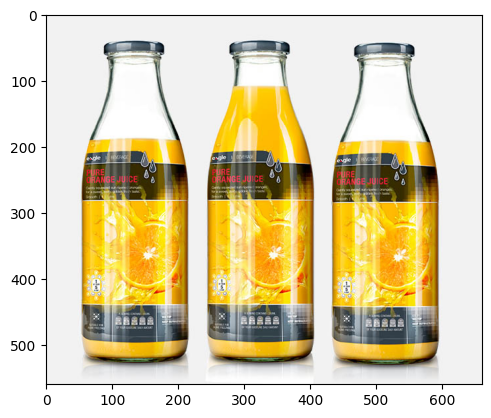

In [4]:
# read in test image
image_url = "https://cdn.eaglepi.com/uploads/2016/08/NEW_Fill_level_Rounded_Image_660pxh.jpg"

image = url_to_image(image_url)
plt.imshow(image)
# Convert to greyscale
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray)

# Method

In the code cells below apply various techniques sequentially to find the fluid levels of the bottles.

You should be able to extract the fluid levels in the bottles in the form of a line(s) (line defined by two points in open CV)

## Step 1: Cropping the image to our area of interest.
I'm choosing to crop the image first before applying all the operations. Assuming that the detection will happen in a factory assembly line and a controlled setting, there should not be much variation in the relativistic positioning of the bottles in the image frame. Hence, it makes sense to fix a rectangular area of pixels as our primary area of interest and crop it first before proceeding with the transformations.

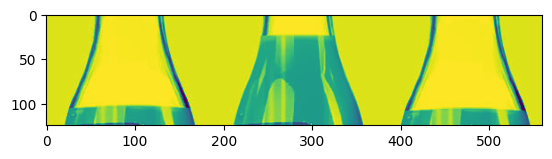

In [5]:
# Cropping the image
croppedOriginal = image[85:210, 40:600]
cropped = cv2.cvtColor(croppedOriginal, cv2.COLOR_BGR2GRAY)
plt.imshow(cropped)

## Step 2: Getting a binary image
Getting a binary image using OpenCV thresholding

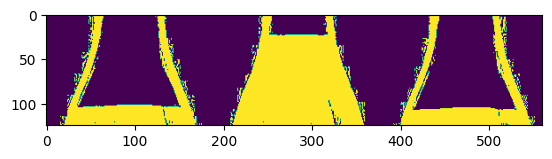

In [6]:
ret, binaryImage = cv2.threshold(cropped,241,255,cv2.THRESH_BINARY_INV)
plt.imshow(binaryImage)

## Step 3: Closing in any gaps

Applying the closing morphology operation to plug in gaps in the image.

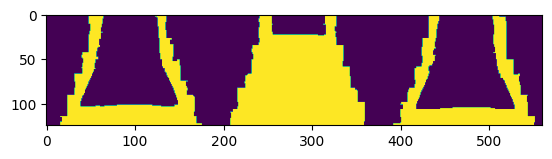

In [7]:
kernel = np.ones((5,5),np.uint8)
closedImg = cv2.morphologyEx(binaryImage, cv2.MORPH_CLOSE, kernel)
plt.imshow(closedImg)

## Step 4: Edge detection
Using the Canny edge detection algorithm to get the required edges (in this case, the liguid levels).

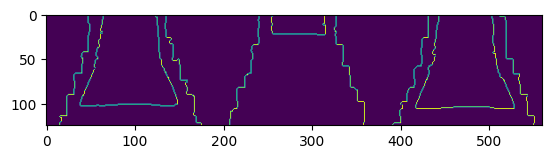

In [8]:
edges = cv2.Canny(closedImg,100,200)
plt.imshow(edges)

## Step 5: Finding the horizontal lines
Using the Hough transformation to identify the horizontal lines.

In [9]:
n_max = 40
#hough lines
rho_res = 1
theta_res = np.pi/180
threshold = 30
min_line_len = 25
max_line_gap = 25

lines = cv2.HoughLinesP(edges,rho_res,theta_res,threshold, np.array([]),
              minLineLength=min_line_len, maxLineGap=max_line_gap)

# print(np.shape(lines))

for line in lines:
    x1,y1,x2,y2 = line[0]
    if np.absolute((y2-y1)/(x2-x1+0.0000001)) <= 0.4: # finding the slope closest to zero to get horizontal lines only. Adding a very negligible value to avoid division by zero errors.
        if y2 < 100:
            cv2.line(croppedOriginal,(x1,y1),(x2,y2),(255,0,0),2)
        else:
            cv2.line(croppedOriginal,(x1,y1),(x2,y2),(0,255,0),2)

# Display

Display the image with the fluid levels overlaid (as in image at the top of the notebook) or otherwise mark the overfilled bottle as Failed or Passed.

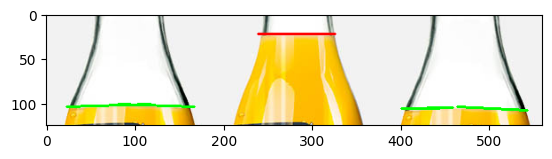

In [10]:
plt.imshow(croppedOriginal)